### This is a code sample where I analyse the data in the LEGO Parts/Sets/Colors and Inventories of every official LEGO set in the Rebrickable database

Database Schema and Data Download URL: https://rebrickable.com/downloads/

##### I hope this analysis leaves a positive impression of myself. This analysis (code + insighting) is done in 2 hours.
##### To view my up-to-date CV, please visit http://bit.ly/cv_giaphattram
##### To view my qualifications, please visit http://bit.ly/giaphattram
##### To see project and code samples, please visit http://www.github.com/giaphattram


## -------------------------------------------------------------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
#path = directory where you keep the .csv files
#os.chdir(path)

# Part 1: Data Processing

### Processing data for part_categories, parts, colors, inventory_parts

In [2]:
part_categories = pd.read_csv("part_categories.csv") #basically just the categories and their ids
part_categories.rename({'name': 'part_cat_name', 'id' : 'part_cat_id'}, axis = 1, inplace = True)
part_categories.head()

part_cat_id            part_cat_name
0            1               Baseplates
1            2           Bricks Printed
2            3            Bricks Sloped
3            4  Duplo, Quatro and Primo
4            5           Bricks Special

In [3]:
parts = pd.read_csv("parts.csv") #Basically actually parts mapped to part_cat_id. Just merge them
parts.rename({'name': 'part_name'}, axis = 1, inplace = True)
parts = pd.merge(left = parts, right = part_categories, left_on = 'part_cat_id', right_on = 'part_cat_id', how = 'left', indicator= True)
print('All parts are merged with the right category: ',parts._merge.nunique()==1)
parts.drop(['part_cat_id', '_merge'], axis = 1, inplace = True)
parts.head()

All parts are merged with the right category:  True


part_num                                          part_name part_cat_name
0   0687b1                        Set 0687 Activity Booklet 1      Non-LEGO
1     0901  Baseplate 16 x 30 with Set 080 Yellow House Print    Baseplates
2     0902  Baseplate 16 x 24 with Set 080 Small White Hou...    Baseplates
3     0903     Baseplate 16 x 24 with Set 080 Red House Print    Baseplates
4     0904  Baseplate 16 x 24 with Set 080 Large White Hou...    Baseplates

In [4]:
colors = pd.read_csv("colors.csv") #basically id-color-rgb mapping
colors.head(2)

id       name     rgb is_trans
0  -1  [Unknown]  0033B2        f
1   0      Black  05131D        f

In [5]:
inventory_parts = pd.read_csv('inventory_parts.csv')
#merge with color
inventory_parts = pd.merge(left = inventory_parts, right = colors, left_on = 'color_id', right_on = 'id', how = 'left')
inventory_parts.head()
inventory_parts.drop(['id', 'rgb','is_trans'], axis = 1, inplace = True)
inventory_parts.rename({'name':'color'}, axis = 1, inplace = True)
#merge with parts
inventory_parts = pd.merge(left = inventory_parts, right = parts, on = 'part_num', how = 'left', indicator = True)
print('Merge successful:', inventory_parts._merge.nunique()==1)
inventory_parts.drop('_merge', axis =1 , inplace = True)
inventory_parts.head()
#There are too many colors. Group similar shades of color together, e.g.: dark blue = light blue = blue
inventory_parts['simplified_color'] = inventory_parts.color.str.split('-').str.join('').str.split(' ').str[-1]
#View to see if there is interesting insights from a pivot of simplified_color and 'part_cat_name'
color_part_pivot = pd.pivot_table(inventory_parts, values = 'quantity', index = 'simplified_color', columns = 'part_cat_name', aggfunc='sum')

Merge successful: True


### Processing data for themes, sets, inventory_sets

In [6]:
themes = pd.read_csv("themes.csv")
themes.rename({'id': 'theme_id', 'name': 'theme_name'}, axis = 1, inplace = True)
themes.head()

theme_id      theme_name  parent_id
0         1         Technic        NaN
1         2  Arctic Technic        1.0
2         3     Competition        1.0
3         4  Expert Builder        1.0
4         5           Model        1.0

In [7]:
sets = pd.read_csv("sets.csv") #each set is connected to a theme, let's merge them
sets.rename({'name': 'set_name'}, axis = 1,inplace = True)
sets = pd.merge(left = sets, right = themes, on = 'theme_id', how = 'left', indicator=True)
print('All rows in sets are merged with a theme: ',sets._merge.nunique()==1)
sets.drop('_merge', axis =1 , inplace = True)
sets.head()

All rows in sets are merged with a theme:  True


set_num                    set_name  year  theme_id  num_parts  \
0    00-1             Weetabix Castle  1970       414        471   
1   001-1                       Gears  1965         1         43   
2  0011-2           Town Mini-Figures  1978        84         12   
3  0011-3  Castle 2 for 1 Bonus Offer  1987       199          2   
4  0012-1          Space Mini-Figures  1979       143         12   

     theme_name  parent_id  
0        Castle      411.0  
1       Technic        NaN  
2  Supplemental       67.0  
3  Lion Knights      186.0  
4  Supplemental      126.0

In [8]:
inventory_sets = pd.read_csv("inventory_sets.csv")
#merge to sets
inventory_sets = pd.merge(left = inventory_sets, right = sets, on = 'set_num', how = 'left', indicator = True)
print('Merging successful: ',inventory_sets._merge.nunique() == 1)
inventory_sets.drop(['_merge'], axis = 1, inplace = True)
inventory_sets.head()

Merging successful:  True


inventory_id  set_num  quantity                    set_name  year  \
0            35  75911-1         1   McLaren Mercedes Pit Stop  2015   
1            35  75912-1         1  Porsche 911 GT Finish Line  2015   
2            39  75048-1         1                 The Phantom  2014   
3            39  75053-1         1                   The Ghost  2014   
4            50   4515-1         1              Straight Rails  1991   

   theme_id  num_parts        theme_name  parent_id  
0       601        340   Speed Champions        NaN  
1       601        570   Speed Champions        NaN  
2       182        234  Star Wars Rebels      158.0  
3       182        928  Star Wars Rebels      158.0  
4       244          8                9V      241.0

In [9]:
year_theme_pivot = pd.pivot_table(data = inventory_sets, index = 'theme_name', columns = 'year', values = 'quantity', aggfunc = 'sum')

### Processing data for mapping themes, sets, inventories, inventory_parts, colors, parts, part_categories

In [10]:
inventories = pd.read_csv("inventories.csv")
print(inventories.shape)
print(inventories.columns)
inventories.head(2)

(14715, 3)
Index(['id', 'version', 'set_num'], dtype='object')


id  version set_num
0   1        1  7922-1
1   3        1  3931-1

In [11]:
inventories_sets_merge = pd.merge(left = inventories, right = sets, on ='set_num', how = 'left', indicator = True)
print('Merging successful: ', inventories_sets_merge._merge.nunique()==1)
inventories_sets_merge.drop(['_merge','parent_id', 'num_parts'], axis = 1, inplace = True)
superMerge = pd.merge(left = inventory_parts, right = inventories_sets_merge, how = 'left', left_on = 'inventory_id', right_on = 'id', indicator = True)
print('Merging successful: ', superMerge._merge.nunique()==1)
superMerge.drop(['_merge', 'version','id'], axis = 1, inplace = True)

Merging successful:  True
Merging successful:  True


In [12]:
color_theme_pivot = pd.pivot_table(data = superMerge, values= 'quantity', index = 'theme_name', columns = 'simplified_color', aggfunc = 'sum')

# Part 2: Data Visualization and Insighting

# First Chart: Quantities of (color, part categories) pairs 
##### 4 tables used: part_categories, parts, inventory_parts, colors

Text(0.5, 1.0, 'Heatmap of Quantities sorted by Simplied Color and Part Categories')

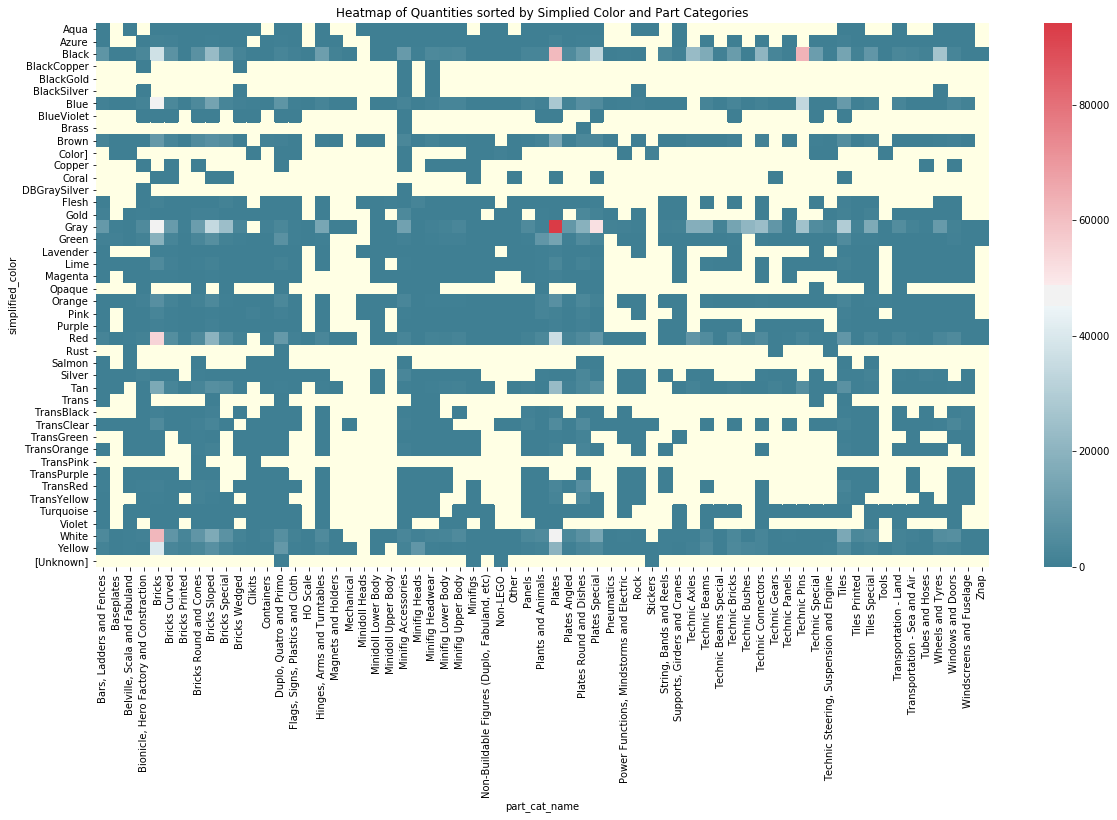

In [13]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize = (20,10))
chart1 = sns.heatmap(color_part_pivot, cmap = cmap, xticklabels=True, yticklabels=True)
chart1.set_facecolor('xkcd:off white')
plt.title('Heatmap of Quantities sorted by Simplied Color and Part Categories')

### Chart 1 Description
This graph is a heatmap of the inventory quantity by any given simplified color and part category pair. The x-axis contains the part categories and the y-axis the simplified colors. Simplified color is a group of different shades of similar colors * . For example, light pink and dark pink are grouped into the same simplified color pink. 
<br>
<br> On the right hand side there is a vertical bar where the color range corresponds with the quantity. The very light yellowish color indicates pairs that do not have data in the dataset. Please note that the darkest shades of blue indicate very low quantity, but not 0. We can treat missing values (light yellowish color) as quantity of 0.
<br>
<br>This heatmap allows for immediately seeing a big picture of the inventory quantity of each pair and identifying the pairs that have no inventory (indicated by light yellowish color), the pairs that have very low quantity (indicated by dark blue), the pairs that have the most inventory (indicated by shades of red), the pairs that have moderately high quantity in inventory (indicated by white). Looking at the graph, 6 pixels in shades of red / light red immediately stands out. 
<br>
<br> The pairs that have the biggest quantity is Gray-Plates,  followed by White-Bricks, Plates-Black, Black-TechnicPins.
<br>
<br> We can also analyze the graph by color or by part category. For example, yellow is the least popular color, and the part category that has a lot of this color is minidoll head and minidoll upperbody. Some of the very popular colors among almost all part categories are BlackCopper, BlackGold, BlackSilver indicated by their long white rows.  (Bionicle, Hero Factory and Constraction) and (Minifig Accessories) are among the part categories that have lowest inventory quantity.
<br>
<br> * Some simplified colors are still actually quite similar, for example BlackSilver and Silver. I don't have enough time to group colors such as these two together.

# Chart 2: Quantities of sets by (year, theme) pairs

##### 3 tables used: inventory_sets, sets, themes

Text(0.5, 1.0, 'Inventory quantity by year-theme')

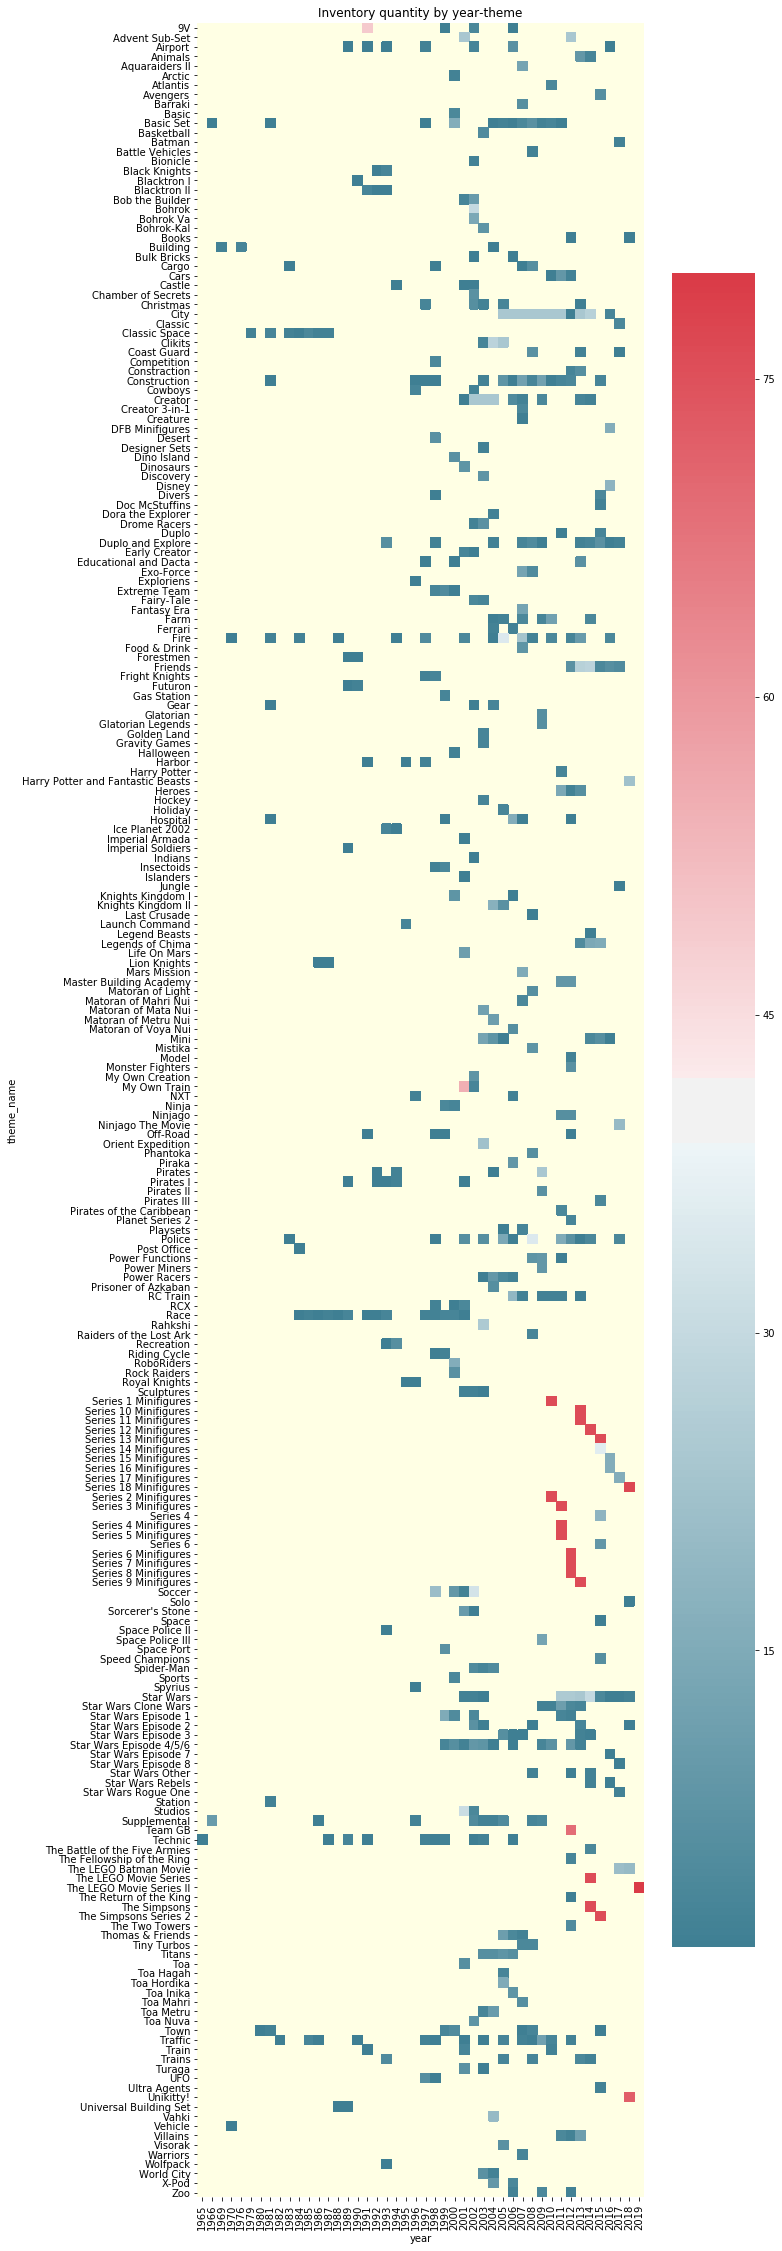

In [14]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize = (10,40))
chart2 = sns.heatmap(year_theme_pivot, cmap = cmap, xticklabels=True, yticklabels=True)
chart2.set_facecolor('xkcd:off white')
plt.title('Inventory quantity by year-theme')

### Chart 2 Description

This graph is a heatmap of the inventory quantity by any given (year, theme) pair. The x-axis contains the years and the y-axis the themes. On the right hand side there is a vertical bar where the color range corresponds with the quantity. The very light yellowish color indicates pairs that do not have data in the dataset. Please note that the darkest shades of blue indicate very low quantity, but not 0. We can treat missing values (ligh yellowish color) as quantity of 0.

This graph allows for immediately seeing which sets are available in which year. For example, 'Vehicle' theme only exists in the inventory in 1970.

We can also immediately see which themes exist in the inventory over many years. For example, 'Forestmen' theme existed in the inventory over the course of 5 years from 2012 to 2017. This could indicate that this theme was a popular trend during those 5 years and is over after 2017. Some themes exist in the inventory across decades. For example, 'Traffic' theme sporadically existed in the inventory between 1982 and 2012.

Another interesting insight is the particularly popular sets colored in red. 'Series [number] minifigures' is a particular successful set of themes, as they have the highest inventories among all themes and across all years. Of course this relies on the assumption that the higher inventory means there is more demand and so Lego produces more and increases the stocks ready for sales. 

# Chart 3: Quantities of sets by (color, theme) pairs

##### All tables are used except inventory_sets

Text(0.5, 1.0, 'Inventory Quantity by Theme-Color')

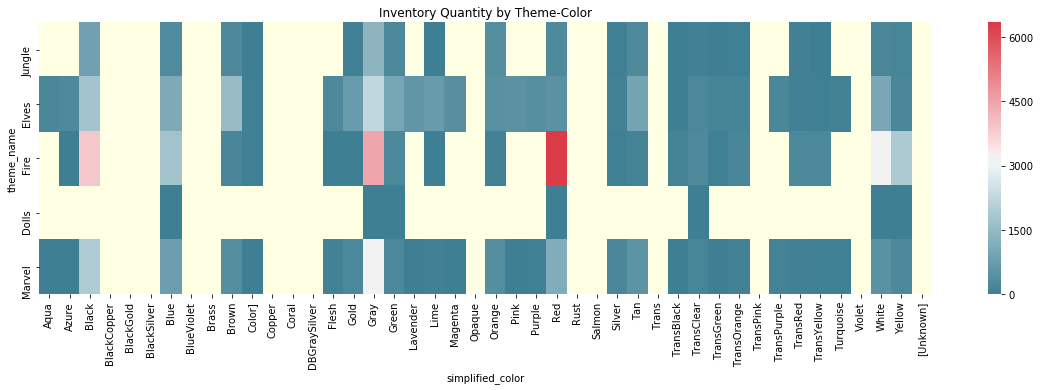

In [15]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize = (20,5))
chart2 = sns.heatmap(color_theme_pivot.loc[['Jungle', 'Elves', 'Fire', 'Dolls', 'Marvel']], cmap = cmap, xticklabels=True, yticklabels=True)
chart2.set_facecolor('xkcd:off white')
plt.title('Inventory Quantity by Theme-Color')

### Chart 3 Description

This graph is a heatmap of the inventory quantity by any given (simplified color, theme) pair. The x-axis contains the themes and the y-axis the simplified colors. On the right hand side there is a vertical bar where the color range corresponds with the quantity. The very light yellowish color indicates pairs that do not have data in the dataset. Please note that the darkest shades of blue indicate very low quantity, but not 0. We can treat missing values (ligh yellowish color) as quantity of 0.

The reason I created this chart is because I want to see if some themes have particular color schemes that are more leaning towards particular simplified colors. I select the following themes: 'Jungle', 'Elves', 'Fire', 'Dolls', 'Marvel'.
<br>
<br>My hypothesis:
<br>
<br>'Jungle' has more green
<br>'Elves' has more white and gray
<br>'Fire' has more red
<br>'Dolls' has more pink
<br>'Marvel' has more black and grey

Graph observation: 
<br>
<br>Surprising, 'Jungle' does not have as many green as they have black.

Most consistent with my hypothesis is the 'Fire' theme, where the total number of parts that have red color is the highest. 'Fire' also 

'Elves' have high number of parts that have the colors black, blue, brown, gray, white; which is reasonable.

'Dolls' surprisingly is the least colorful, having parts with only blue, gray, green, red, transclear, white and yellow.

'Marvel' is more colorful than I expected. Gray is the dominant color in the theme "Marvel", followed by black, consistent with my hypothesis.

# Chart 4: Total set quantity in inventory by year

Text(0, 0.5, 'Quantity')

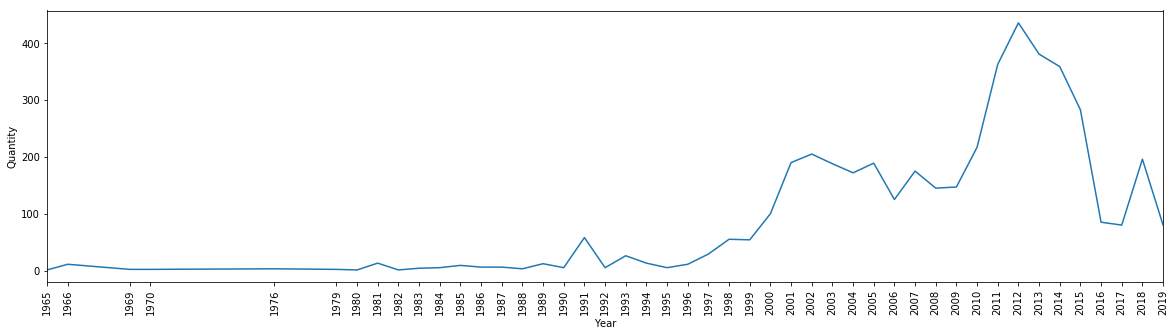

In [16]:
setByYear = inventory_sets.groupby('year')['quantity'].sum()
plt.figure(figsize=(20,5))
setByYear.plot(xticks = setByYear.index, rot = 90)
plt.xlabel('Year')
plt.ylabel('Quantity')

### Chart 4 Description

This chart shows the total number of sets in the inventory by year. Naturally, we would expect more recent years to have larger inventories as the company LEGO gets bigger. 

However, it could be observed that the inventories were increasing significantly following the financial crisis in 2008. The stock buildup stops in 2012 and started to go down afterwards. This could mean that after the financial crisis, Lego sales were going down, so stock was built up. After 2012, the economy was recovering and sales started to increasing, thereby reducing stock buildup.

Another reason I create this chart is that since I used heatmap for all the charts above, I may create an impression that I can only create heat map. I just found the heatmaps useful for the questions I have in mind. This chart is to show that I can create any chart.

## ------------------------------------The End------------------------------------------------------------